In [292]:
import pandas as pd
import numpy as np

In [293]:
df= pd.read_csv("CostReport_2022_Final.csv")

In [294]:
df.head()

,rpt_rec_num,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,...,Net Income from Service to Patients,Total Other Income,Total Income,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone CHIP,Stand-Alone CHIP Charges
0,717629,344028,STRATEGIC BEHAVIORAL CENTER - GARNER,3200 WATERFIELD ROAD,GARNER,NC,27529-7727,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,717969,180078,PAUL B. HALL REGIONAL MEDICAL CENTER,PAUL B. HALL REGIONAL MEDICAL CENTE,PAINTSVILLE,KY,41240,JOHNSON,99918.0,R,...,634470.0,2151392.0,2785862.0,15.0,2785847.0,0.074617,1114125.0,26708472.0,NaN,NaN
2,719460,520210,MARSHFIELD MEDICAL CENTER-EAU CLAIRE,2116 CRAIG ROAD,EAU CLAIRE,WI,54701,NaN,20740.0,U,...,-4259661.0,845990.0,-3413671.0,151877.0,-3565548.0,0.451411,14333809.0,18797586.0,NaN,NaN
3,719475,63037,COBALT REHAB HOSP WESTMINSTER,6500 WEST 104TH AVE,WESTMINSTER,CO,80020,NaN,79740.0,U,...,-1980346.0,NaN,-1980346.0,NaN,-1980346.0,NaN,NaN,NaN,NaN,NaN
4,721379,340123,AMERICAN HEALTHCARE SYSTEMS,373 NORTH FAYETTEVILLE STREET,ASHEBORO,NC,27204-,RANDOLPH,24660.0,U,...,-5248749.0,-6661015.0,-11909764.0,NaN,-11909764.0,0.160752,1724073.0,6249901.0,NaN,NaN


In [295]:
#filter to work only with Florida
df_fl = df[df['State Code'] == 'FL'].copy()
df_fl.head()
df_fl.shape

(259, 117)

In [296]:
#Drop NaN values from Total Patient and total Operating Expenses

df_fl= df_fl.dropna(subset=['Total Patient Revenue', 'Less Total Operating Expense'])
df_fl.shape

(253, 117)

In [297]:
#Remove outliers from Total Patient Revenue

def oultier_remover(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df_clean = oultier_remover(df_fl, 'Total Patient Revenue')
df_clean.shape

(239, 117)

Cluster by hospital structure

In [298]:
#cluster the data
cluster_features = [
    'Rural Versus Urban',       # categorical
    'Number of Beds',           # numeric
    'CCN Facility Type'         # categorical
]

In [299]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate types
numeric_features = ['Number of Beds']
categorical_features = ['Rural Versus Urban', 'CCN Facility Type']

# Create transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [300]:
from sklearn.cluster import KMeans

# Create pipeline
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', KMeans(n_clusters=5, random_state=42))  # Adjust k 
])

# Drop rows with missing values
df_cluster_input = df_clean.dropna(subset=cluster_features)

# Fit the pipeline
clustering_pipeline.fit(df_cluster_input)

# Cluster labels
df_clean.loc[df_cluster_input.index, 'cluster'] = clustering_pipeline['clusterer'].labels_


df_clean[['Hospital Name', 'Number of Beds', 'Rural Versus Urban', 'CCN Facility Type', 'cluster']].head()


/var/folders/5t/2ljl_q6s3l3199mchzqglklc0000gn/T/ipykernel_2572/3201414901.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[df_cluster_input.index, 'cluster'] = clustering_pipeline['clusterer'].labels_


,Hospital Name,Number of Beds,Rural Versus Urban,CCN Facility Type,cluster
87,ORLANDO HEALTH-HEALTH CENTRAL HOSPIT,284.0,U,STH,3.0
88,ORLANDO HEALTH SOUTH LAKE HOSPITAL,167.0,U,STH,1.0
89,SARASOTA MEMORIAL HOSPITAL,787.0,U,STH,0.0
90,ST. CLOUD REGIONAL MEDICAL CENTER,84.0,U,STH,1.0
91,VIERA HOSPITAL INC,84.0,U,STH,1.0


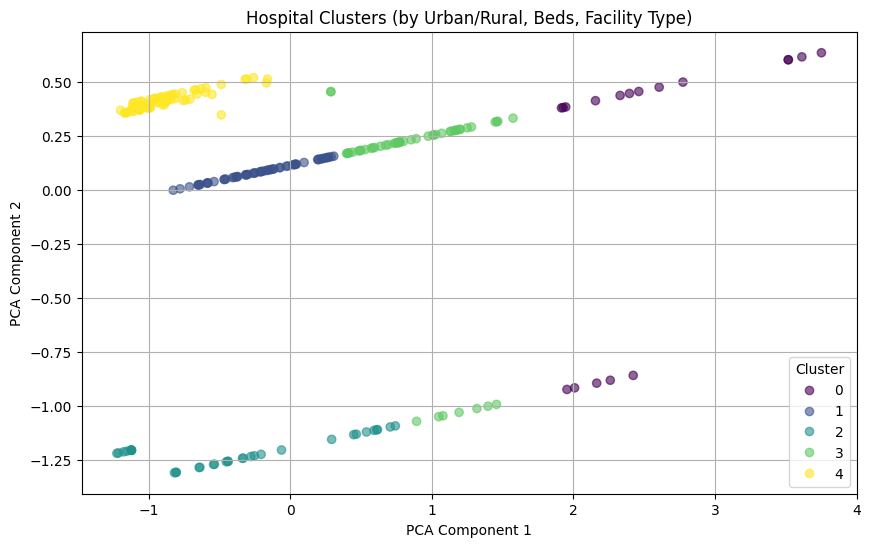

In [301]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions for visualization
X_cluster_scaled = clustering_pipeline['preprocessor'].transform(df_cluster_input)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering_pipeline['clusterer'].labels_, cmap='viridis', alpha=0.6)
plt.title('Hospital Clusters (by Urban/Rural, Beds, Facility Type)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()


Multiple Linear Regression (MLR) model to identify the most important hospital expenses
Linear Regression to control, optimize, and explain hospital costs!

In [302]:
#Select only cluster 0 for further analysis
df_clean=df_clean[df_clean['cluster'] == 4].copy()

In [303]:
df_clean.shape

(76, 118)

In [304]:
y = df_clean['Total Patient Revenue']
#input features
expense_cols = [
    'Total Salaries From Worksheet A',
    'Overhead Non-Salary Costs',
    'Depreciation Cost',
    'Total Costs',
    'Wage-Related Costs (Core)',
    'Wage-Related Costs (RHC/FQHC)',
    'Total Salaries (adjusted)',
    'Contract Labor: Direct Patient Care',
    'Wage Related Costs for Part - A Teaching Physicians',
    'Wage Related Costs for Interns and Residents',
    'Cost of Charity Care',
    'Total Other Expenses'
]
X=df_clean[expense_cols]
X.isnull().sum()
# Fill NaN values with 0
X=X.fillna(0)
X.isnull().sum()

Total Salaries From Worksheet A                        0
Overhead Non-Salary Costs                              0
Depreciation Cost                                      0
Total Costs                                            0
Wage-Related Costs (Core)                              0
Wage-Related Costs (RHC/FQHC)                          0
Total Salaries (adjusted)                              0
Contract Labor: Direct Patient Care                    0
Wage Related Costs for Part - A Teaching Physicians    0
Wage Related Costs for Interns and Residents           0
Cost of Charity Care                                   0
Total Other Expenses                                   0
dtype: int64

In [305]:
#Standarize the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Fit Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_scaled, y)
#Predict
y_pred = model.predict(X_scaled)

#Feature Importance
for feature, coef in zip(expense_cols, model.coef_):
    print(f"{feature}: {coef:.4f}")
#Calculate R^2 
from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print(f"R^2: {r2:.4f}")
#Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE: {rmse:.4f}")

Total Salaries From Worksheet A: -77700240.8716
Overhead Non-Salary Costs: 27494706.8882
Depreciation Cost: -30521303.0481
Total Costs: 197456675.7242
Wage-Related Costs (Core): -86801552.7761
Wage-Related Costs (RHC/FQHC): -0.0000
Total Salaries (adjusted): 53258170.5491
Contract Labor: Direct Patient Care: 18909790.9628
Wage Related Costs for Part - A Teaching Physicians: 0.0000
Wage Related Costs for Interns and Residents: 0.0000
Cost of Charity Care: 0.0000
Total Other Expenses: 27915918.5135
R^2: 0.8871
RMSE: 47283051.1182


In [306]:
#now check p-values
import statsmodels.api as sm
#add constant to the model
X_scaled_with_const = sm.add_constant(X_scaled)
#fit the model
model_sm = sm.OLS(y, X_scaled_with_const).fit()
#summary
print(model_sm.summary())


/Users/cbardalesm/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                              OLS Regression Results                             
Dep. Variable:     Total Patient Revenue   R-squared:                       0.887
Model:                               OLS   Adj. R-squared:                  0.874
Method:                    Least Squares   F-statistic:                     65.78
Date:                   Fri, 25 Apr 2025   Prob (F-statistic):           9.79e-29
Time:                           21:56:35   Log-Likelihood:                -1450.9
No. Observations:                     76   AIC:                             2920.
Df Residuals:                         67   BIC:                             2941.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.094e+08 

In [307]:
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = ['const'] + expense_cols
vif_data["VIF"] = [variance_inflation_factor(X_scaled_with_const, i) for i in range(X_scaled_with_const.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))


                                              feature         VIF
2                           Overhead Non-Salary Costs  109.746404
1                     Total Salaries From Worksheet A   47.588156
4                                         Total Costs   45.908688
7                           Total Salaries (adjusted)   35.704806
5                           Wage-Related Costs (Core)   32.371778
3                                   Depreciation Cost    8.227811
12                               Total Other Expenses    1.990428
8                 Contract Labor: Direct Patient Care    1.510289
0                                               const    1.000000
6                       Wage-Related Costs (RHC/FQHC)         NaN
9   Wage Related Costs for Part - A Teaching Physi...         NaN
10       Wage Related Costs for Interns and Residents         NaN
11                               Cost of Charity Care         NaN


/Users/cbardalesm/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [308]:
# Drop high-VIF features
X_reduced = X.drop(columns=['Total Costs', 'Total Salaries (adjusted)', 'Overhead Non-Salary Costs'])

# Rescale new X_reduced
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Correct VIF calculation without const
vif_data = pd.DataFrame()
vif_data["feature"] = list(X_reduced.columns)  # NO 'const'
vif_data["VIF"] = [variance_inflation_factor(X_reduced_scaled, i) for i in range(X_reduced_scaled.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


print(vif_data.sort_values(by="VIF", ascending=False))


                                             feature       VIF
0                    Total Salaries From Worksheet A  7.110785
1                                  Depreciation Cost  7.093754
4                Contract Labor: Direct Patient Care  1.296959
2                          Wage-Related Costs (Core)  1.267362
8                               Total Other Expenses  1.223438
3                      Wage-Related Costs (RHC/FQHC)       NaN
5  Wage Related Costs for Part - A Teaching Physi...       NaN
6       Wage Related Costs for Interns and Residents       NaN
7                               Cost of Charity Care       NaN
                                             feature       VIF
0                    Total Salaries From Worksheet A  7.110785
1                                  Depreciation Cost  7.093754
4                Contract Labor: Direct Patient Care  1.296959
2                          Wage-Related Costs (Core)  1.267362
8                               Total Other Expenses  1

/Users/cbardalesm/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Lasso for Feature Reduction

In [309]:
X_lasso = X_reduced_scaled
y_lasso = y


In [310]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_lasso, y_lasso)

# Best alpha selected
print("Best alpha:", lasso.alpha_)


Best alpha: 4782813.056195998


In [311]:
# Feature importance
lasso_coef = pd.Series(lasso.coef_, index=X_reduced.columns)

#features to drop
print("Features to drop (Lasso):")
print(lasso_coef[lasso_coef == 0])


Features to drop (Lasso):
Depreciation Cost                                      0.0
Wage-Related Costs (RHC/FQHC)                          0.0
Wage Related Costs for Part - A Teaching Physicians    0.0
Wage Related Costs for Interns and Residents           0.0
Cost of Charity Care                                   0.0
dtype: float64


In [312]:
features_to_drop = lasso_coef[lasso_coef == 0].index.tolist()
X_lasso_selected = X_reduced.drop(columns=features_to_drop)


In [313]:
#refit the model
scaler_final = StandardScaler()
X_lasso_selected_scaled = scaler.fit_transform(X_lasso_selected)
# Fit the model

X_lasso_selected_scaled_const = sm.add_constant(X_lasso_selected_scaled)

model_final = sm.OLS(y, X_lasso_selected_scaled_const).fit()

# Print the detailed results
print(model_final.summary())


                              OLS Regression Results                             
Dep. Variable:     Total Patient Revenue   R-squared:                       0.769
Model:                               OLS   Adj. R-squared:                  0.756
Method:                    Least Squares   F-statistic:                     59.13
Date:                   Fri, 25 Apr 2025   Prob (F-statistic):           7.10e-22
Time:                           21:56:35   Log-Likelihood:                -1478.1
No. Observations:                     76   AIC:                             2966.
Df Residuals:                         71   BIC:                             2978.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.094e+08 

Gradient Boosting to see if there is an improvement in R^2
Gradient Boosting for prediction tests

In [314]:
from sklearn.ensemble import GradientBoostingRegressor


In [315]:
# Set up the Gradient Boosting model
gbr = GradientBoostingRegressor(
    n_estimators=500,  # Number of boosting stages (trees)
    learning_rate=0.05,  # How much each tree corrects
    max_depth=3,  # Depth of each tree (controls overfitting)
    random_state=42
)


In [316]:
gbr.fit(X_lasso_selected_scaled, y)


GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=42)

In [317]:
# Make predictions
y_pred_gbr = gbr.predict(X_lasso_selected_scaled)

# Evaluate model
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("R² (Gradient Boosting):", r2_score(y, y_pred_gbr))
print("RMSE (Gradient Boosting):", np.sqrt(mean_squared_error(y, y_pred_gbr)))


R² (Gradient Boosting): 0.999463247714583
RMSE (Gradient Boosting): 3259701.4065565025


In [318]:
#Gradient Boosting is good for maximum prediction accuracy 

Benchmark Model
Compare bserved vs predicted y
Efficiency Score = Actual Revenue / Predicted Revenue

Hospitals that perform better than expected will have Efficiency > 1
Hospitals that perform worse than expected will have Efficiency < 1

In [320]:
efficiency_score = y / y_pred
#Add efficiency score to the DataFrame
df_clean['Efficiency Score'] = efficiency_score

df_clean[['Hospital Name', 'Total Patient Revenue', 'Efficiency Score']].head()
print(df_clean['Efficiency Score'].describe())

count     76.000000
mean       4.111854
std       27.796321
min      -11.562400
25%        0.767001
50%        0.916565
75%        1.091709
max      242.687813
Name: Efficiency Score, dtype: float64


In [ ]:
#mean efficiency score = 4, means that the hospital is 4 times more efficient than the average hospital in the dataset
#median efficiency score = 0.91, half of the hospital are slightly inefficient
#standard deviation = 27,79, extremely spreaded

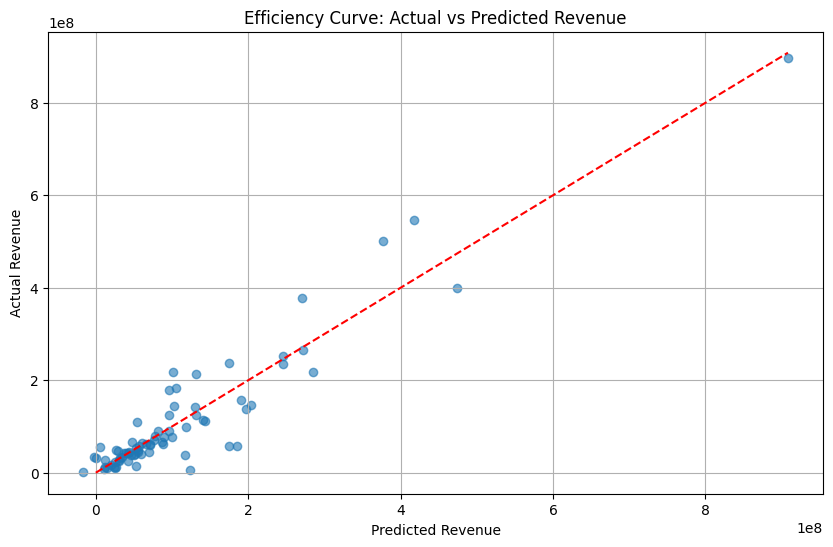

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))


plt.scatter(y_pred, y, alpha=0.6)

# perfect efficiency line
max_val = max(max(y_pred), max(y)) #check the maximum value between y_pred and y
plt.plot([0, max_val], [0, max_val], '--r')

# Labels
plt.xlabel('Predicted Revenue')
plt.ylabel('Actual Revenue')
plt.title('Efficiency Curve: Actual vs Predicted Revenue')
plt.grid(True)
plt.show()


In [322]:
#rank Hopsitals by efficiency score
df_clean['Efficiency Rank'] = df_clean['Efficiency Score'].rank(ascending=False)

# Sort and view top performers
df_clean_sorted = df_clean.sort_values(by='Efficiency Score', ascending=False)

df_clean_sorted[['Hospital Name', 'Efficiency Score', 'Efficiency Rank']].head(10)


,Hospital Name,Efficiency Score,Efficiency Rank
741,ENCOMPASS HEALTH REHABILITATION HOSP,242.687813,1.0
4566,SEA PINES REHABILITATION HOSPITAL A,10.939248,2.0
1051,ENCOMPASS HEALTH REHABILITATION OF P,2.233984,3.0
1881,ADVENTHEALTH CONNERTON,2.167905,4.0
511,FT. LAUDERDALE HOSPITAL,2.041516,5.0
4389,SSH - GAINESVILLE INC,1.858577,6.0
5109,LIFESTREAM BEHAVIORAL CENTER,1.835459,7.0
4737,KINDRED HOSPITAL THE PALM BEACHES,1.736488,8.0
4688,SSH - MIAMI,1.626841,9.0
4570,ENCOMPASS HEALTH REHABILITATION HOSP,1.617854,10.0


In [ ]:
#Clean outliers again to avoid extreme values (noise, data entry errors, superstart hospitals, other)

lower_threshold = 0.5
upper_threshold = 2.0


df_clean_filtered = df_clean[
    (df_clean['Efficiency Score'] >= lower_threshold) &
    (df_clean['Efficiency Score'] <= upper_threshold)
].copy()

# Check how many hospitals left
print("Hospitals after outlier cleaning:", df_clean_filtered.shape[0])

Hospitals after outlier cleaning: 62


In [328]:
# Rank hospitals based on Efficiency Score
df_clean_filtered['Efficiency Rank'] = df_clean_filtered['Efficiency Score'].rank(ascending=False)

# Sort best and worst
df_sorted = df_clean_filtered.sort_values(by='Efficiency Score', ascending=False)


In [329]:
# Top 5 Hospitals
print("Top 5 Most Efficient Hospitals:")
print(df_sorted[['Hospital Name', 'Efficiency Score']].head(5))

# Bottom 5 Hospitals
print("\nBottom 5 Least Efficient Hospitals:")
print(df_sorted[['Hospital Name', 'Efficiency Score']].tail(5))


Top 5 Most Efficient Hospitals:
                             Hospital Name  Efficiency Score
4389                 SSH - GAINESVILLE INC          1.858577
5109          LIFESTREAM BEHAVIORAL CENTER          1.835459
4737     KINDRED HOSPITAL THE PALM BEACHES          1.736488
4688                           SSH - MIAMI          1.626841
4570  ENCOMPASS HEALTH REHABILITATION HOSP          1.617854

Bottom 5 Least Efficient Hospitals:
                             Hospital Name  Efficiency Score
4652                      SSH - FORT MYERS          0.695969
829       REHABILIATION HOSPITAL OF NAPLES          0.669019
740   ENCOMPASS HEALTH REHABILITATION HOSP          0.630606
1489                THE WILLOUGH AT NAPLES          0.585970
1052  ENCOMPASS HEALTH REHABILITATION HOSP          0.537320
